## MaxVol Paper 


### Results

Plots of wasserstein distance evolution for cLHS, Maxvol and Random samplings


_______

tg: @misha_grol and anna.petrovskaia@skoltech.ru

In [ ]:
# Uncomment for Google colab
# !pip install maxvolpy

# !git clone https://github.com/EDSEL-skoltech/maxvol_sampling
    
# %cd maxvol_sampling/

In [3]:
from scipy.spatial import voronoi_plot_2d, Voronoi
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from numpy import genfromtxt
import pandas as pd
import numpy as np
import gdal

%matplotlib inline

import xarray as xr
import clhs as cl
import csv
import seaborn as sns
import argparse
# import osgeo.gdal as gdal
import os

from scipy.spatial import distance
from scipy.stats import entropy
from scipy.special import kl_div
from scipy.stats import ks_2samp
from scipy.stats import wasserstein_distance

# from data_preparation import data_preparation
# from maxvol_cut import rect_maxvol_cut, f_no_cut, f_penal_2D
# from tools import norm_data, add_coords, gen_input, extend_score, points_selection, f_no_cut, f_cut_eps, calc_score, good_points_brute_force, idx_to_idx


from src.util import MaxVolSampling

## Settings for matplotlib __ELSEVIER__ style

In [3]:
plt.rcParams["font.family"] = "Times New Roman"

plt.rcParams.update({'font.size': 16})


In [4]:
# plt.style.use(['science', 'grid'])

plt.rcParams["font.family"] = "Times New Roman"

plt.rcParams.update({'font.size': 16})


# plt.rcParams['xtick.labelsize'] =20
# plt.rcParams['ytick.labelsize'] =20


Parameter: Moisture_perc_10.npy
Parameter: Moisture_perc_30.npy
Parameter: Moisture_perc_80.npy
Parameter: mean_yeild_c_per_ha.npy
Parameter: pen_resist_10.npy
Parameter: pen_resist_30.npy
Parameter: pen_resist_80.npy
Parameter: temp_10.npy
Parameter: temp_30.npy
Parameter: temp_80.npy


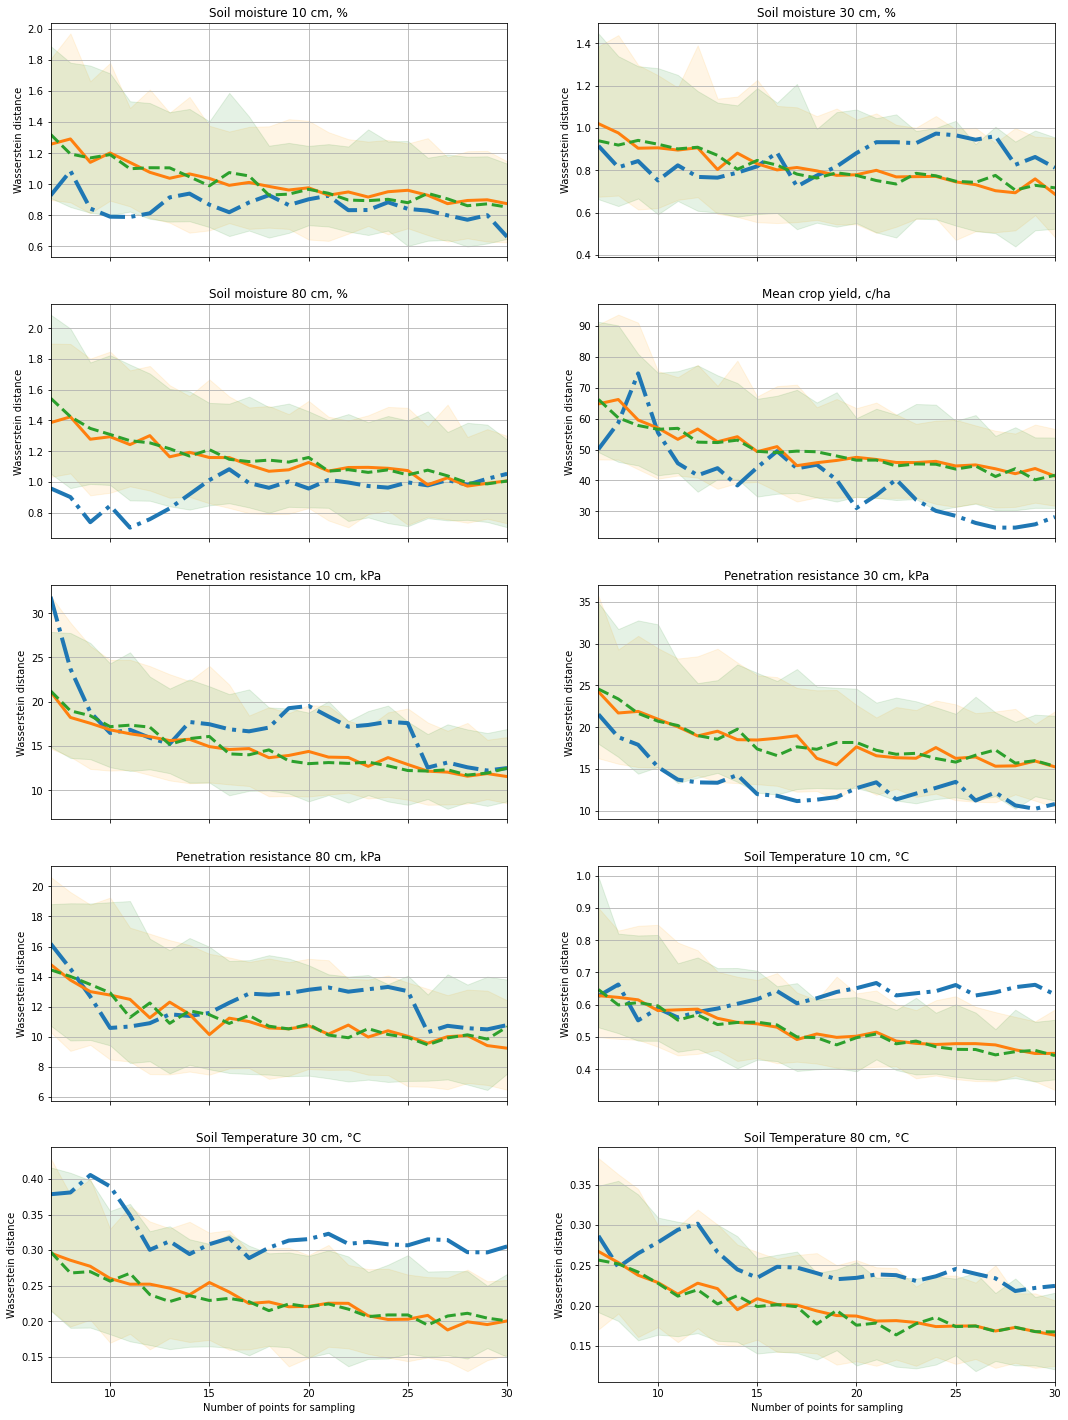

In [8]:
fig, ((ax0, ax1), (ax2, ax3), (ax4, ax5), (ax6, ax7),(ax8, ax9))  = plt.subplots(nrows=5, ncols=2, sharex=True,figsize=(18, 25))

names_for_plots  = ['Soil moisture 10 cm, %','Soil moisture 30 cm, %',
                    'Soil moisture 80 cm, %','Mean crop yield, c/ha',
                    'Penetration resistance 10 cm, kPa','Penetration resistance 30 cm, kPa',
                    'Penetration resistance 80 cm, kPa', 'Soil Temperature 10 cm, °C',
                    'Soil Temperature 30 cm, °C','Soil Temperature 80 cm, °C']
path = './experiments/cLHS_10_000/exp_fem_poins/npy_files/'
files_with_points = os.listdir(path)

range_files_allocation=[]
for file in files_with_points:
    range_files_allocation.append(np.load(os.path.join(path,file), allow_pickle=True)[None])
    res = np.load(os.path.join(path,file), allow_pickle=True)

dict_for_indices = {'MAXVOL':[], 'cLHS':[], 'Random':[]}
from collections import ChainMap
for sampling in [*range_files_allocation[0][0].keys()]:
    loc_list = [dict(loc_dict[0][sampling]) for loc_dict in range_files_allocation]
    dict_for_indices[sampling] = dict(ChainMap(*loc_list))
n = 0
number_of_points = range(7,31)
csv_file_to_process = './src/data_v0.csv'

for row in ((ax0, ax1), (ax2, ax3), (ax4, ax5), (ax6, ax7),(ax8, ax9)):
    for col in row:
        
        # COMPUTE WASSERSTEIN DISTANCE
        
        df_name = list(pd.read_csv(csv_file_to_process,  sep=',').columns)
        soil_parameters = df_name
        path_to_inter_npy_files = './experiments/cLHS_10_000/Interpolation_data/'
        np.random.seed(42)
        units = ['Soil moisture 10 cm, %','Soil moisture 30 cm, %','Soil moisture 80 cm, %','Mean crop yield, c/ha', 'Penetration resistance 10 cm, kPa','Penetration resistance 30 cm, kPa','Penetration resistance 80 cm, kPa', 'Soil Temperature 10 cm, °C','Soil Temperature 30 cm, °C','Soil Temperature 80 cm, °C']
        interpolation_files = sorted(os.listdir('./experiments/cLHS_10_000/Interpolation_data/'))
        print('Parameter:', interpolation_files[n])
        dict_for_plots  = {'MAXVOL':{},
                             'cLHS':{}, 
                             'Random':{}}
        dict_for_new_maxvol = {'MAXVOL_NEW': {}}
        for points in number_of_points:
            SAR = MaxVolSampling()
            SAR.soil_feature = soil_parameters[n]
            SAR.num_of_points = points
            SAR.soil_data = pd.read_csv(csv_file_to_process,  sep=',')
            SAR.path_to_file_with_indices = None
            SAR.wd = './DEM_files//'

            SAR.path_to_interpolation_file = os.path.join(path_to_inter_npy_files, interpolation_files[n])
            _  =SAR.data_preparation(SAR.wd, data_m=3, dem_dir = None)
            SAR.original_soil_data(SAR.soil_feature)
            interpolation_map = SAR.interpolation_array[::-1]
            MAXVOL_ = interpolation_map[SAR.i_am_maxvol_function()]

            # List to iterate over 100 realization of cLHS and Random
            cLHS_ = [interpolation_map[dict_for_indices['cLHS'][points][i]] for i in range(100)]
            Random_ = [interpolation_map[dict_for_indices['Random'][points][i]] for i in range(100)]
            dict_for_plots['MAXVOL'][points] = wasserstein_distance(SAR.original_data, MAXVOL_)
            dict_for_plots['cLHS'][points] = [wasserstein_distance(SAR.original_data, mdt) for mdt in cLHS_]
            dict_for_plots['Random'][points] = [wasserstein_distance(SAR.original_data, mdt) for mdt in Random_]
            
        quantile_lower_random = np.array([np.quantile(dict_for_plots['Random'][i], .10) for i in number_of_points])
        quantile_upper_random = np.array([np.quantile(dict_for_plots['Random'][i], .90) for i in number_of_points])
        median_random = np.array([np.median(dict_for_plots['Random'][i]) for i in number_of_points])

        
        
        quantile_lower_cLHS = np.array([np.quantile(dict_for_plots['cLHS'][i], .10) for i in number_of_points])
        quantile_upper_cLHS = np.array([np.quantile(dict_for_plots['cLHS'][i], .90) for i in number_of_points])
        median_cLHS = np.array([np.median(dict_for_plots['cLHS'][i]) for i in number_of_points])
        
        col.plot(number_of_points, [*dict_for_plots['MAXVOL'].values()], '-.',label='Maxvol',linewidth=4,markersize=10 )
        col.plot(number_of_points, median_random, label='Random median',linewidth=3,markersize=10 )
        col.plot(number_of_points, median_cLHS,'--',label='cLHS median',linewidth=3,markersize=14)
        col.fill_between(number_of_points, quantile_lower_random, quantile_upper_random , alpha=0.1, color='orange', label='CI Random')
        col.fill_between(number_of_points, quantile_lower_cLHS, quantile_upper_cLHS , alpha=0.1, color='green', label='CI cLHS')
        
        col.set_xlim(min(number_of_points), max(number_of_points))
#         col.set_xticks(number_of_points)
        col.set_title(names_for_plots[n])
        col.grid(True)
        col.set(ylabel="Wasserstein distance")
        if n==8 or n==9:
            
            col.set(xlabel="Number of points for sampling", ylabel="Wasserstein distance")


#         plt.show()
        n+=1
# plt.legend()
# plt.savefig('../plots/agricultural_systems_plots/plots_with_evolution_of_wassersterin/wasserstein_disctance_IQR.png', dpi=300)
# plt.savefig('../plots/agricultural_systems_plots/plots_with_evolution_of_wassersterin/nwasserstein_disctance_IQR.svg')    